# Deep learning from scratch: Final Exam

## General instructions

**1. Complete the problems listed below in this Jupyter notebook - leaving all of your code in Python cells in the notebook itself. Feel free to add any necessary cells.**

**2. The exam is due Wednesday (3/21) at 11:59 pm. Late submissions will NOT be accepted.**

**3. Make sure you have put your name at the top of this notebook.**

**4. This is the only file you will submit, so make sure all output is present in your notebook prior to submission.**

**5. This exam will be graded out of 60. The last problem (problem 4) is worth 20 points of extra credit. **    

In [1]:
# Activate this cell to import Python packages + custom libraries

# import autograd functionalities
import autograd.numpy as np
from autograd import grad as compute_grad   

# import plotting library and other necessities
import matplotlib.pyplot as plt
from matplotlib import gridspec

# import general libraries
import copy
from datetime import datetime 

# import custom 
import normalizers
from my_convnet_lib import superlearn_setup as setup

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

import sys
sys.path.append('../../')

from timeit import default_timer as timer

%load_ext autoreload
%autoreload 2

------

#### <span style="color:#a50e3e;">Problem 1. </span> Short-answer questions (30 points)

Provide a short answer (1-2 sentences maximum) to each each of the following questions. 

------

**1. Why can't we use random search - a zero order method of optimization - to find the optimal weights of a deep learning model?** 

Curse of dimentionality.
The search space increases exponetially whne dimentionality increases. Since the expected number of steps to come close enough to tthe global minimum is porpotional to the search space. It is infeasible since most ML applications has mnay weights to be tuned.


------

**2. Why is the Least Squares cost rarely used in linear classification?**

Because the cost function will then looks like what is shown in 9.1 (3) of the textbook:
\begin{equation}
g(w_0,w_1) = \frac{1}{P}\sum_{p=1}^P \left(\text{sign}\left(w_0 + x_pw_1 \right) - y_p \right)^2
\end{equation}

This function is not only non-differentiable, but also have 0 gradient on its differentiable sections. This property  prohibits the use of many efficient optimization methods such as SGD.

------

**3. What is the major difference between One-versus-All (OvA) classification and multiclass softmax classification?** 

OVA classification trains one binary classifier on each class. To classify multiclass data, it simply pick the class where the binary classifier gives the strongest probability (farest away form the separation line).

Using multiclass softmax, the model consider the training data as a whole. It have the potential to achieve higher accuracy by alleviate the need to classify each class correctly. The learned separation line may no longer classify any individual class correctly, however, when combined, they have the potential to classify the multiclass dataset better.



------

**4. Why does gradient descent tend to zig-zag in long narrow valleys? What is one way to fix this issue?**

On the slope of a long narrow valley, gradient does no point to the golbal minimum, instead, it points almost perpendicular to it. As a result, following the gradient will usually leand to the other side of the slope, not the bottom, causing gradient decent to go back and forth. Evan if gradient do points to global minimum in some unlikely cases, it is easy to jump past the goal (step size too large) to other side of the valley when the valley is too narrow. 

Apply normolization to the data can help reduce the likelyhood of long valley or shorten them. Shrinking the step size in each round can reduce zig-zaging around the global minimum. Another solution is to use momentum gradient decent tha tmitigate the zig-zaging effect.

------

**5. What is the case for normalizing gradient descent in deep learning?**

In traditional gradient decent, the step is controled by the magnitude of gradient along with the step size. As a reuslt, we can not fully controll the actual step length taken at each step.

Normalized gradient decent give us the control by normolizing the gradient into unit vector. Doing so allow us to effective shrink the step length by reducing the stepsize when we are near the minimum. Since the gradient is not guaranteed to diminish near the minimum, doing so help us get closer to the minimum. 

------

**6. A convolutional layer that uses ```ReLU```, i.e., $\max{\left(0, \cdot\right)}$, as nonlinear activation together with ```max-pooling``` as pooling function, is redundant in the sense that we can simplify it by removing the nonlinear activation module in the middle without changing the results. Is that true or false? Explain.**  
<figure><img src="pics/conv_layer.png" width="90%"></figure>

In most cases, maybe.
Since ReLU transform negative values to 0, and leave non-negative values untouched. It is only used when all input the the pooling window is negative, otherwise, the max pooling will select the maximum that is not touched by ReLU.
In practical cases, it is rarely the case that a pooling window will consists only negative values. As a reult, ReLU is generally not used. However, thechinically, it is not completely redundant.

------

#### <span style="color:#a50e3e;">Problem 2. </span> CNN vs. MLP (10 points)

In this exercise you will compare the efficacy - in terms of validation error - of two learners: a multilayer perceptron and an associated convnet constructed by layering a single convolutional layer (convolution + pooling) on top of multilayer perceptron.  To do this you will employ a library called `my_convnet_lib` that employs exactly the code you have seen developed this quarter for building optimizers, input normalization, multilayer perceptrons, and convolutional layers.  

A note on jargon: in practice the lower multilayer perceptron portion of a convolutional network is often called its *fully connected layers*, and often in this context multilayer perceptrons are called *fully connected networks*.  

#### Loading in the data

In terms of the experiment - you will use a subset of size $P = 10,000$ the MNIST handwritten digit dataset (of size $70,000$) which you can load in below.  We will call this sample of input/output points `x` and `y` respectively

In [5]:
# load in full MNIST dataset
datapath = 'data/MNIST_subset.csv'
data = np.loadtxt(datapath,delimiter = ',')

# import data and reshape appropriately
x = data[:-1,:]    # input
y = data[-1:,:]    # corresponding output

#### Contrast normalization

Now - before we do any sort of processing, remember we are dealing with images so we should *contrast normalize* them.  To do this we simply *standard normalize* each image.  This is done below employing a backend file `normalizers.py` (which contains many of the input normalizers discussed in class).

In [6]:
# contrast normalize our sample of images - by standard normalizing each one
normalizer,inverse_normalizer = normalizers.standard(x.T)
x = normalizer(x.T).T

We will normalize our input a second time - here using ZCA sphereing - in order to speed up our optimizer's ability to find good minima.  However, as shown with previous libraries, this step is built into the library API below.

#### MLP  run

Below we demonstrate the use of the convolutional network library `my_convnet_lib` to employ a multilayer perceptron / fully connected network to perform classification on our dataset.  Lets go through the API calls shown below line-by-line (or more appropriately, step-by-step).


** Step 1: initialize an instance of the library controller **

In the first line we create an instance of the main controller of the library - called `Setup`.  This takes in the data we wish to perform classification on, `x` and `y`.


** Step 2: initialize a convolutional layer **

In the second line we initialize a convolutional layer for our learner.  The main argument for this constructor is the our desired kernel sizes, defined by the `kernel_sizes` variable.  There are also other optional arguments we can input to define our convolutional layer like those shown, including `conv_stride` (by default set to $1$ as detailed in class) to control the stride of our convolution pass and `pool_stride` (by default set to $2$ as detailed in class) to control the stride of our pooling step.  

For now this step is commented out, since here we want a multilayer perceptron.


** Step 3: initialize a multilayer perceptron / fully connected layer **

This looks very much like the previous version of the library you played with in homework.  Here we define crucial parameters of our multilayer perceptron / fully connected network, including: the activation function used at each layer, the number of hidden layers, the number of hidden units in each layer, and the type of supervised learning we are performing.  Note: here we have improved the UI of the `hidden_layers` variable.  Previously its first and last element were defined to be the dimension of the input / output data respectively.  However now these two parameters are just set on the backend, and so the example given below

```layer_sizes = [10,10,10];```

does indeed define a fully connected network with $3$ hidden layers, and $10$ units per layer.  Also note that the parameter `name` defines whether we use a standard or batch-normalized perceptron scheme in each layer.  By default we have set it too the latter as

```name = multilayer_perceptron_batch_normalized```

You can choose the standard scheme by setting `name` as follows

```name = multilayer_perceptron```

Finally, the `activation` can be set to a variety of functions, like `tanh`, `relu`.

So far we have seen various activation functions, most notably the tanh and relu functions defined below

\begin{array}
\
a(x) = \text{tanh}(w_0 + w_1x) \\
a(x) = \text{max}(0,w_0 + w_1x) \\
\end{array}

Here you will implement the so-called [*maxout* activation](https://arxiv.org/pdf/1302.4389.pdf).  This function, defined as

\begin{array}
\
a(x) = \text{max}(v_0 + v_1x, \,w_0 + w_1x) \\
\end{array}

takes maximum of two linear combinations of the input, instead of one linear combination and zero like the relu function.  While this change is algebraically rather minor, multilayer perceptron architectures employing the *maxout* activation tends to have certain advantages over those employing tanh and relu activations, including

- fewer issues with problematic initialization  e.g., values close too (or equal to) zero for the *relu* activation are bad because the relu is minimized at zero

- fewer issues with gradients vanishing or exploding, as can occur when using the tanh activation

- faster convergence with far fewer gradient descent steps

These advantages come with a simple price: the maxout activation has twice as many internal parameters as either the relu or tanh, hence architectures built with them have roughly twice as many parameters to tune.


** Step 4: split the data into training and validation sets **

Here we split our input data into a training and validation portions.  Remember: we want to measure how well our `model` fits the data based on its *validation* error, not its training error.  Here the variable `train_portion` defines whcih portion of the input data is reserved for training, with the remaining portion set aside for validation purposes.


** Step 5: choose an input normalization scheme **

Here we choose an input normalizer - here set to `ZCA_sphere` for ZCA sphereing.


** Step 6: choose cost function **

Pretty straightforward.  For multiclass classification you can choose from the multiclass softmax function `multiclass_softmax` or multiclass perceptron `multiclass_perceptron`.


** Step 7: optimizer **

Here we run gradient based optimization using mini-batches.  Here the input variables `max_its`, `alpha_choice`, and `batch_size` control the number of iterations (epochs = full sweeps through the data), steplength parameter, and size of mini-batch respectively.  Note that after each complete sweep through the data - called an *epoch* - an update including the time to completion, and current training / validation cost values are printed.


** Step 8: plot training and validation histories **

Here we plot the training and validation cost function histories in the left panel, and the corresponding accuracies at each step in the right panel.

Running the cell below will produce the training / validation histories shown afterwards.  Notice how the validation cost bottoms out fairly early, increasing for the remaining iterations.  However the validation accuracy reaches its peak somewhere in the middle of the run. 

<IPython.core.display.Javascript object>


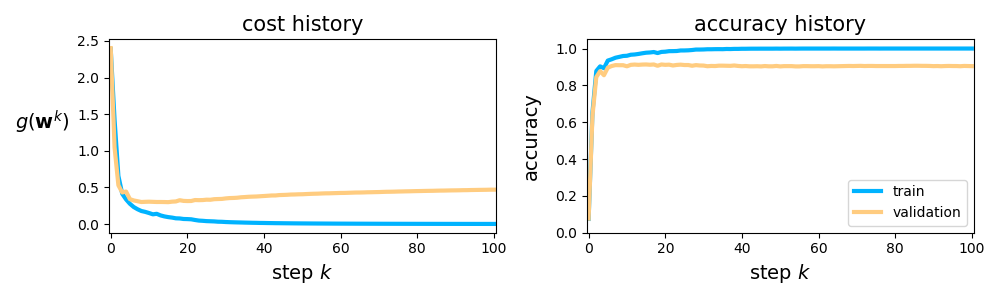

In [7]:
# Step 1: import the setup module of our convnet library
mylib1 = setup.Setup(x,y)

# Step 2: define convolution layer

# Step 3: define fully connected / multilayer perceptron layers
layer_sizes = [10,10,10];
name = 'multilayer_perceptron_batch_normalized'
super_type = 'classification'
activation = 'maxout'
mylib1.choose_features(name = name,layer_sizes = layer_sizes,super_type = super_type,activation = activation)

# Step 4: split data into training and testing sets
mylib1.make_train_val_split(train_portion = 0.8)

# Step 5: choose input normalization scheme
mylib1.choose_normalizer(name = 'ZCA_sphere')

# Step 6: choose cost function
mylib1.choose_cost(name = 'multiclass_softmax')

# Step 7: run optimization algo
mylib1.fit(max_its = 100, alpha_choice = 10**(0),batch_size = 500)

# Step 8: Plot training / validation histories
mylib1.show_histories(start = 0)

To pluck out the best validation accuracy - the measurement we really care about here - run the cell below.

In [8]:
# pluck out the highest validation accuracy from the run above
ind1 = np.argmax(mylib1.val_accuracy_histories[0])
best_result1 = mylib1.val_accuracy_histories[0][ind1]
print ('from this run our best validation accuracy was ' + str(np.round(best_result1*100,2)) + '% at step ' + str(ind1))

from this run our best validation accuracy was 91.35% at step 15


#### CNN run

The same code used above is copied below, with the convolutional layer defined and added, plus a slight change to Step 4 (to make sure we use the same training / validation data in the next experiment).  The parameters of Step 3 - where you defined your fully connected layers - is the same here. The number of convolutional kernels will be set by you. 

Note: even though we have optimized the convolutional layer (and fully connected layers) for processing on multiple cpu cores, depending on your machine each step (or *epoch*) could take some time to complete.  For this reason, you have the option to increase the `conv_stride` from $1$ to $2$ or even larger - this may decrease the efficacy of the convolutional layer but will at the same time significantly decrease the amount of computation required (indeed the computation decreases *quadratically* with this parameter), yet you should still be able to make significant improvement over the previous network.

Make a run with a maximum of around $20$ steps to see how much you can improve the validation accuracy with this simple convolutional network in comparison to the multilayer perceptron used above.

In [18]:
# number of 3x3 convolutional kernels to learn (set by you)
num_kernels = 16

# convolution stride (set by you)
conv_stride = 2

<IPython.core.display.Javascript object>


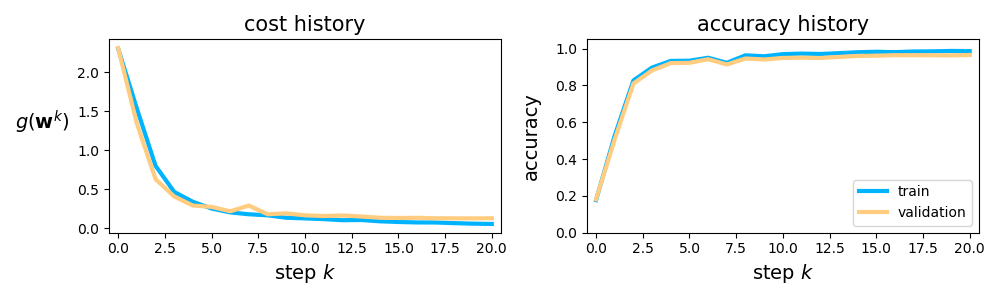

In [19]:
# Step 1: import the setup module of our convnet library
mylib2 = setup.Setup(x,y)

# Step 2: define convolution layer
kernel_sizes = [num_kernels,3,3]
pool_stride = 2
mylib2.choose_convolutions(kernel_sizes = kernel_sizes,conv_stride = conv_stride, pool_stride = pool_stride)

# Step 3: define fully connected / multilayer perceptron layers
layer_sizes = [10,10,10];
name = 'multilayer_perceptron_batch_normalized'
super_type = 'classification'
activation = 'maxout'
mylib2.choose_features(name = name,layer_sizes = layer_sizes,super_type = super_type,activation = activation,scale = 0.1)

# Step 4: split data into training and testing sets
mylib2.x_train = mylib1.x_train
mylib2.y_train = mylib1.y_train
mylib2.x_val = mylib1.x_val
mylib2.y_val = mylib1.y_val

# Step 5: choose input normalization scheme
mylib2.choose_normalizer(name = 'ZCA_sphere')

# Step 6: choose cost function
mylib2.choose_cost(name = 'multiclass_softmax')

# Step 7: run optimization algo
mylib2.fit(max_its = 20, alpha_choice = 10**(0), batch_size = 500)

# Step 8: Plot training / validation histories
mylib2.show_histories(start = 0)

In [20]:
# pluck out the highest validation accuracy from the run above
ind2 = np.argmax(mylib2.val_accuracy_histories[0])
best_result2 = mylib2.val_accuracy_histories[0][ind2]
print ('from this run our best validation accuracy was ' + str(np.round(best_result2*100,2)) + '% at step ' + str(ind2))

from this run our best validation accuracy was 96.5% at step 20


**Question: How much - in terms of percentage of validation accuracy -  was the overall classification improved after adding a single convolutional layer?** 

Using 16 filters with stide 2. We improved the accuracy by 5.15%

-----

#### <span style="color:#a50e3e;">Problem 3. </span> Humpty Dumpty! (20 points)

Randy is collecting data for two different machine learning tasks. Task A is to predict whether a student passes or fails a certain test based on their past academic record. Task B is to predict whether a debtor defaults on their debt based on their past financial record. The dataset for each task has $P=100$ datapoints. 

When saving the data, Randy messed up and forgot to put the input features and labels together, and now he doesn't remember which label vector $\mathbf{y}$ goes with which input matrix $\mathbf{X}$. Can you help Randy pair them correctly? 

Activate the cell below to load Randy's data.

In [22]:
# load in X_A: input data for task A
X_A = np.loadtxt('data/X_A.txt', delimiter=',')

# load in X_B: input data for task B
X_B = np.loadtxt('data/X_B.txt', delimiter=',')

# load in y1: one of the label vectors, we don't know what task it belongs to!  
y1 = np.reshape(np.loadtxt('data/y1.txt', delimiter=','), (-1,1)).T

# load in y2: the other label vector! we don't know what task it belongs to! 
y2 = np.reshape(np.loadtxt('data/y2.txt', delimiter=','), (-1,1)).T

To answer this question, first come up with a strategy and explain the rationale behind it, i.e., why you think it should work. Then use your strategy to connect the $\mathbf{X}$'s to the $\mathbf{y}$'s.  

Hint: you can use our deep learning library introduced in Problem 2.   

My strategy is fitting it using a MLP. A correct match should result in higher accuracy than a mismatch.

Since the data is samll, we should use simple modles. We try the same architecture as in Problem 2.

In [28]:
acc = []
# classify on a combination of them
for x in [X_A, X_B]:
    for y in [y1, y2]:
        mylib1 = setup.Setup(x,y)
        layer_sizes = [10, 10, 10];
        name = 'multilayer_perceptron_batch_normalized'
        super_type = 'classification'
        activation = 'tanh'
        mylib1.choose_features(name = name,layer_sizes = layer_sizes,super_type = super_type,activation = activation)
        mylib1.make_train_val_split(train_portion = 0.6)
        mylib1.choose_normalizer(name = 'sphere')
        mylib1.choose_cost(name = 'softmax')
        mylib1.fit(max_its = 100, alpha_choice = 10**(-1), batch_size = 10, verbose = False)
        #mylib1.show_histories(start = 0)
        ind1 = np.argmax(mylib1.val_accuracy_histories[0])
        best_result1 = mylib1.val_accuracy_histories[0][ind1]
        acc.append(best_result1)
i = 0
for x in ["X_A", "X_B"]:
    for y in ["y1", "y2"]:
        print("Accuracy training " + x + " using " + y + ": " + str(acc[i]))
        i += 1

Accuracy training X_A using y1: 0.675
Accuracy training X_A using y2: 1.0
Accuracy training X_B using y1: 1.0
Accuracy training X_B using y2: 0.675


$\mathbf{y}_1$ corresponds to task B

$\mathbf{y}_2$ corresponds to task A

----------

#### <span style="color:#a50e3e;">Problem 4. </span> The minimum is just a single step away! (20 points of extra credit)

Forming the Least Squares regression cost on a dataset with scalar input (i.e., $N=1$) has resulted in the following quadratic cost function

$$g(\mathbf{w}) = \frac{1}{2} \mathbf{w}^T\mathbf{A}\mathbf{w}+\mathbf{b}^T\mathbf{w}+c$$

where $\mathbf{w} = \begin{bmatrix} w_0 \\ w_1 \end{bmatrix}$ contains the bias parameter $w_0$ and the slope parameter $w_1$, $\mathbf{A} = \begin{bmatrix} 1\,\,1 \\ 1 \,\, 4\end{bmatrix}$, $\mathbf{b} = \begin{bmatrix} -1 \\ 0 \end{bmatrix}$, and $c=3$.

 We want to employ gradient descent to (precisely) reach the minimum of $g$, starting at the initial point $\mathbf{w}^{0} = \begin{bmatrix} 1 \\ 1 \end{bmatrix}$. Here's the catch: we are only allowed to take <strong>one</strong> gradient descent step!

---------

**I. Can this be done using vanilla gradient descent (Eq. 2 in [Section 6.4](https://jermwatt.github.io/mlrefined/blog_posts/6_First_order_methods/6_4_Gradient_descent.html))? If yes, provide the value of the steplength parameter $\alpha$ that makes it happen. If no, explain why not.**

Since A is symetric, we have:
\begin{equation*}
\nabla{g}=\frac{\partial g(\mathbf{w})} {\partial w} = \mathbf{A}\mathbf{w}+\mathbf{b}
\end{equation*}
At global minimum, we have 0 gradient. solving for:
\begin{equation*}
\mathbf{A}\mathbf{w}+\mathbf{b} = 0
\end{equation*}
We get the global minimum at:
\begin{equation*}
\mathbf{w}=-\mathbf{A^{-1}}\mathbf{b}= -\begin{bmatrix} \frac{4}{3}\,\,\frac{-1}{3} \\ \frac{-1}{3}  \,\, \frac{1}{3} \end{bmatrix} \begin{bmatrix} -1 \\ 0 \end{bmatrix} = \begin{bmatrix} \frac{4}{3} \\ -\frac{1}{3}\end{bmatrix}
\end{equation*}
The direction to the global minimum is then:
\begin{equation*}
\begin{bmatrix} \frac{4}{3} \\ -\frac{1}{3}\end{bmatrix} - \begin{bmatrix} 1 \\ 1 \end{bmatrix} = \begin{bmatrix} \frac{1}{3} \\ \frac{-4}{3} \end{bmatrix}
\end{equation*}
The gradient at initialize point is:
\begin{equation*}
\nabla{g(\mathbf{w}^0)}=\begin{bmatrix} 1\,\,1 \\ 1 \,\, 4\end{bmatrix}\begin{bmatrix} 1 \\ 1 \end{bmatrix}+\begin{bmatrix} -1 \\ 0 \end{bmatrix}=\begin{bmatrix} 1 \\ 5 \end{bmatrix}
\end{equation*}
Which is not opposite to the direction to the global minimum, thus, we can't reach the global minimum in one step no matter what the stepsize is.

---------

**II. Can this be done using normalized gradient descent (Eq. 2 in [Section 13.3](https://jermwatt.github.io/mlrefined/blog_posts/13_Multilayer_perceptrons/13_3_Normalized_gradient_descent.html))? If yes, provide the value of the steplength parameter $\alpha$ that makes it happen. If no, explain why not.**

As the same reason as in previous question. Since the negative gradient deos not point to the global minimum. Going a unit length in that direction can not reach the global minimum.

---------

**III. Can this be done using gradient descent with momentum (Eq. 1 in [Section 13.4](https://jermwatt.github.io/mlrefined/blog_posts/13_Multilayer_perceptrons/13_4_Momentum_methods.html))? If yes, provide the values of the steplength parameter $\alpha$ and momentum parameter $\beta$ that make it happen. If no, explain why not.**

We have:
\begin{equation}
\mathbf{w}^{k+1} = \mathbf{w}^k - \alpha \nabla g\left(\mathbf{w}^k\right) + \beta \left(\mathbf{w}^{k} - \mathbf{w}^{k-1}\right)
\end{equation}
Given that $\mathbf{w}^{k-1}=0$, it reduces to:
\begin{equation}
\mathbf{w}^{k+1} = \mathbf{w}^k - \alpha \nabla g\left(\mathbf{w}^k\right) + \beta \mathbf{w}^{k}
\end{equation}
Let $\mathbf{w}^{k+1}=\begin{bmatrix} \frac{4}{3} \\ -\frac{1}{3}\end{bmatrix}$, $\mathbf{w}^{k}=\begin{bmatrix} 1 \\ 1\end{bmatrix}, \nabla{g(\mathbf{w}^k)}=\begin{bmatrix} 1 \\ 5 \end{bmatrix}$
The equation becomes:
\begin{equation}
\begin{bmatrix} \frac{4}{3} \\ -\frac{1}{3}\end{bmatrix} = \begin{bmatrix} 1 \\ 1\end{bmatrix} - \alpha \begin{bmatrix} 1 \\ 5 \end{bmatrix} + \beta \begin{bmatrix} 1 \\ 1\end{bmatrix}
\end{equation}
Solving the equation gives:
\begin{equation}
\alpha=\frac{5}{12}, 
\beta=\frac{3}{4}
\end{equation}

---------

**IV. Repeat part III, this time for a general $N$ dimensional input. That is, $\mathbf{A}$ is now a symmetric $(N+1)\times (N+1)$ matrix, $\mathbf{b}$ an $(N+1)\times 1$ vector, and $c$ still a scalar. Is it possible to reach the global minimum of $g$ in one step using the momentum trick regardless of how $\mathbf{w}^{0}$ is initialized? If yes, provide the values of steplength parameter $\alpha$ and momentum parameter $\beta$ that make it happen (in terms of $\mathbf{A}$, $\mathbf{b}$, $c$, and $\mathbf{w}^{0}$). If no, explain why not.**

We have:
\begin{equation}
-\mathbf{A^{-1}}\mathbf{b} = \mathbf{w}^0 - \alpha (\mathbf{A}\mathbf{w}^0+\mathbf{b}) + \beta \mathbf{w}^{0}
\end{equation}
We can rewrite it as:
\begin{equation}
(\beta+1) \mathbf{w}^{0} + (-\alpha) (\mathbf{A}\mathbf{w}^0+\mathbf{b}) = -\mathbf{A^{-1}}\mathbf{b}
\end{equation}
Which means that if a solution of $\alpha$ and $\beta$ exits, the vector $-\mathbf{A^{-1}}\mathbf{b}$ must be able to be writen as a linear combination of $\mathbf{w}^{0}$ and $(\mathbf{A}\mathbf{w}^0+\mathbf{b})$. While it can always be done in 2-D space when the 2 vectors are non-parallel, it is unlike to be always be possible at higher dimensions, especially when the basis of the vector space (N+1) is much larger than 2. A linear combination of 2 vecotrs can only represent a tiny fraction of vectors in such space. 

Here is an counter example in 3-D space:
\begin{equation}
\mathbf{b} = \begin{bmatrix} 0 \\ 0 \\ 0\end{bmatrix}, \mathbf{w}^0 = \begin{bmatrix} 1 \\ 1 \\ 1\end{bmatrix}, \mathbf{A} = \begin{bmatrix} 1\,\,0\,\,0 \\ 0\,\,1\,\,0 \\ 0\,\,0\,\,2\end{bmatrix}
\end{equation}
We have:
\begin{equation}
(\beta+1) \begin{bmatrix} 1 \\ 1 \\ 1\end{bmatrix} + (-\alpha) \begin{bmatrix} 1 \\ 1 \\ 2\end{bmatrix} = \begin{bmatrix} 0 \\ 0 \\ 0\end{bmatrix}
\end{equation}
The above equation have no solution for $\alpha$ and $\beta$

Which menas it is not always possible to do so in higher dimensional cases.